In [35]:
from commonfunctions import *
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


- **Preprocessing**: Enhance bubbles using adaptive thresholding and morphological operations (closing/dilation) to ensure solid shapes.
- **ROI Extraction**: Detect the student ID box and the answers area using contour analysis (looking for large rectangular regions).
- **Generic Bubble Detection**:
    - Use `cv2.findContours` to find all potential bubbles.
    - Filter contours by area, aspect ratio, and circularity.
    - Group bubbles into rows (questions) and columns (choices) based on their spatial coordinates.
- **Mark Detection**: Calculate the mean intensity or pixel density of each bubble area to identify the filled choice.
- **Grading & Export**: Compare results with the model answer and export to Excel using `export_excel` from `commonfunctions`.


In [41]:
def detect_inner_box(image):
    """
    Detects the inner box (main form area) of the bubble sheet.
    Returns the warped image containing only the inner form.
    """
    # If the image is already grayscale, use it; otherwise, convert it.
    if len(image.shape) == 3:
        gray = rgb2gray(image)
    else:
        gray = image
    
    # Scale to 0-255 uint8 if necessary
    if gray.dtype != np.uint8:
        gray = (gray * 255).astype(np.uint8)

    # Use a fixed threshold to find the black borders
    _, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if not contours:
        return image

    # Sort contours by area and get the largest one
    contours_sorted = sorted(contours, key=cv2.contourArea, reverse=True)
    
    # Get the largest contour (the outer box)
    largest_contour = contours_sorted[0]
    
    peri = cv2.arcLength(largest_contour, True)
    approx = cv2.approxPolyDP(largest_contour, 0.02 * peri, True)

    # We are looking for a rectangle (4 points)
    if len(approx) == 4:
        # Warp the image to this inner rectangle
        return four_point(image, approx.reshape(4, 2))
            
    return image

(4032, 3024, 3)
(3469, 2788)


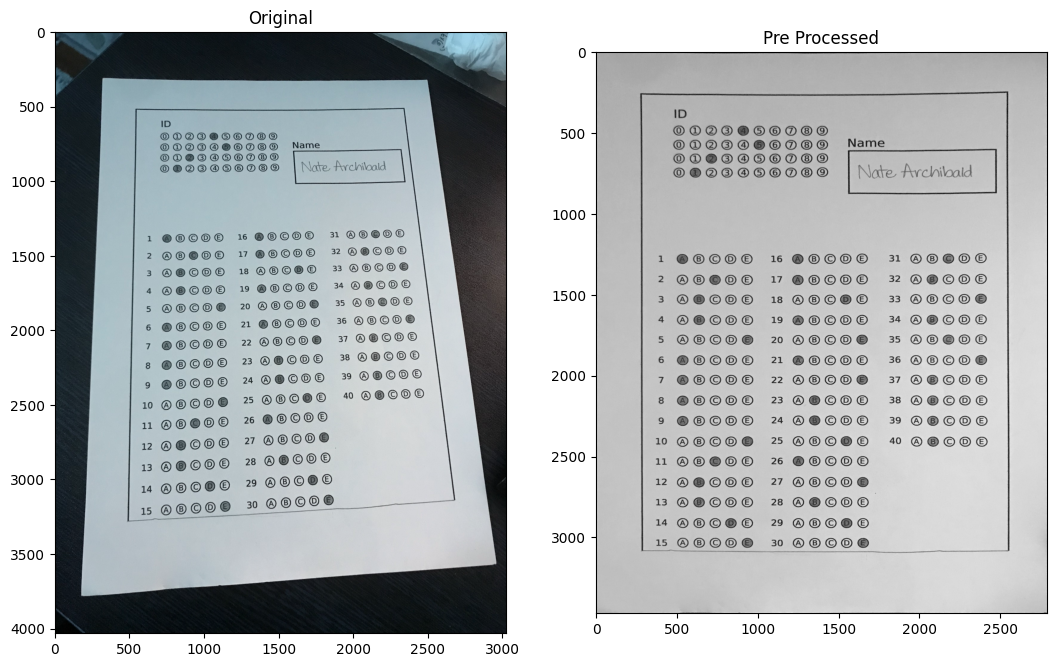

In [37]:
## Read Image
image = cv2.imread("./Bubble_Sheet_Dataset/3/ID4Q40CH5/IMG_2029.jpg")
print(image.shape)
pre_processed_image = preprocessing(image)
print(pre_processed_image.shape)
show_images([image, pre_processed_image], ["Original", "Pre Processed"])

In [38]:
def find_bubbles(image_gray):
    """
    Detects bubbles in a grayscale image and returns them grouped by rows.
    This approach is generic and handles different numbers of questions/choices.
    """
    # convert the gray image (0 -> 1) to uint8 type and multiply by 255 becuase adaptiveThreshold function
    # deals with this type
    img_uint8 = (image_gray * 255).astype(np.uint8) if image_gray.dtype != np.uint8 else image_gray
    
    # get the binary image image because findCountours deals with binary only
    # we chose the invesrsed binary threshold because this is the type expected by findContours function
    _, binary_image = cv2.threshold(img_uint8, 165, 255, cv2.THRESH_BINARY_INV)

    # apply closing to fill the gaps in the circles which are marked.
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    closed = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, kernel)
    show_images([image_gray, binary_image, closed], ['Original Gray', 'Inverse Binary Image', 'Closed Image'])

    # contours is a Python list of all the contours in the image.
    # Each individual contour is a Numpy array of (x,y) coordinates of boundary points of the object.
    # [[(x1,y1), (x2, y2)], [(x1,y1), (x2, y2)], [(x1,y1), (x2, y2)]]
    # we use RETR_EXTERNAL to only find external boundaries and ignore inner circles in letters like 'd' 
    # and numbers like '9' or '0'
    contours, _ = cv2.findContours(closed, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    bubbles = []
    for cnt in contours:
        (x, y, w, h) = cv2.boundingRect(cnt)

        # The ratio of the width to the height of the bubble
        # A perfect circle or square has an aspect ratio of 1.0.
        aspect_ratio = w / float(h) 

        ## countour area (number of pixels in this contour)
        area = cv2.contourArea(cnt) 

        perimeter = cv2.arcLength(cnt, True)
        if perimeter == 0: continue

        circularity = 4 * np.pi * (area / (perimeter * perimeter))
        
        # Filter based on area and aspect ratio
        if  circularity >= 0.77 and area > 1000 and aspect_ratio > 0.83:
            bubbles.append((x, y, w, h, cnt))
            
    if not bubbles:
        return []

    # group the bubbles into rows (Questions)
    # sort bubbles by their top-to-bottom position (y-coordinate)
    bubbles = sorted(bubbles, key=lambda b: b[1])
    
    rows = []
    if bubbles:
        current_row = [bubbles[0]]
        for i in range(1, len(bubbles)):
            # If the current bubble's Y is close to the previous one, it's the same row
            # threshold is roughly half the height of a bubble
            if abs(bubbles[i][1] - current_row[-1][1]) < (bubbles[i][3] / 2):
                current_row.append(bubbles[i])
            else:
                # Sort the completed row by left-to-right (x-coordinate)
                rows.append(sorted(current_row, key=lambda b: b[0]))
                current_row = [bubbles[i]]
        rows.append(sorted(current_row, key=lambda b: b[0]))
        
    return rows

# def get_marked_choice(row_bubbles, image_gray):
#     """
#     Identifies which bubble in a row is marked based on pixel density.
#     """
#     marked_index = -1
#     max_density = -1
    
#     # Ensure image is in [0, 1] range for consistent density calculation
#     if image_gray.max() > 1.0:
#         image_gray = image_gray / 255.0
        
#     for i, (x, y, w, h, cnt) in enumerate(row_bubbles):
#         # Create a mask for this specific bubble contour
#         mask = np.zeros(image_gray.shape, dtype="uint8")
#         cv2.drawContours(mask, [cnt], -1, 255, -1)
        
#         # Calculate the average darkness in this area
#         mask_bool = mask > 0
#         mean_val = np.mean(image_gray[mask_bool])
        
#         # The darker the bubble (lower mean intensity), the more likely it's filled
#         density = 1.0 - mean_val
        
#         if density > max_density:
#             max_density = density
#             marked_index = i
            
#     # Threshold to ensure it's actually marked (not empty)
#     if max_density < 0.5: 
#         return -1
        
#     return marked_index


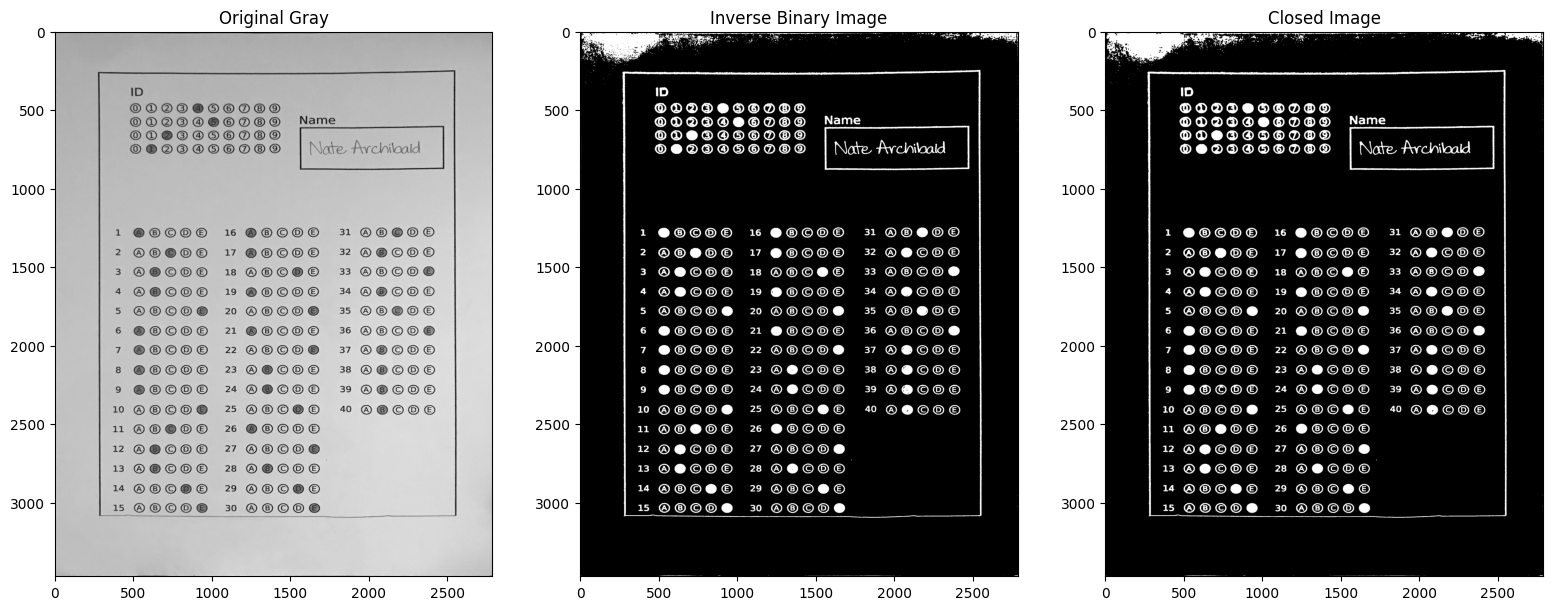

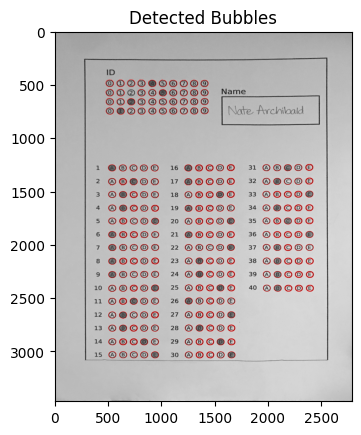

In [39]:
rows = find_bubbles(pre_processed_image)

# Create a copy to draw on (convert grayscale back to RGB so we can draw in color)
viz_image = cv2.cvtColor((pre_processed_image * 255).astype(np.uint8), cv2.COLOR_GRAY2RGB)

# 3. Loop through the detected rows and bubbles
for row in rows:
    for (x, y, w, h, cnt) in row:
        # Draw a green rectangle around the detected bubble
        # cv2.rectangle(viz_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        
        # Optionally draw the actual contour in red
        cv2.drawContours(viz_image, [cnt], -1, (255, 0, 0), 2)

# 4. Show the result
show_images([viz_image], ["Detected Bubbles"])

In [44]:
import easyocr
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Initialize EasyOCR (only needs to run once)
reader = easyocr.Reader(['en'], gpu=False)
print("EasyOCR initialized successfully!")

Using CPU. Note: This module is much faster with a GPU.


EasyOCR initialized successfully!


## Step 2: Find the ID/Name Text Box
The text box is located in the top-right area of the form. We'll use contour detection to find rectangular regions and filter for the text box based on:
- Position (top portion of the image)
- Aspect ratio (wider than tall)
- Size (large enough to contain text)

Image size: 2788x3469, dtype: uint8
  Candidate box: x=1566, y=611, w=904, h=267, aspect=3.39, area_ratio=0.0250
  Candidate box: x=1557, y=604, w=921, h=281, aspect=3.28, area_ratio=0.0268

✓ Found text box at: x=1557, y=604, width=921, height=281


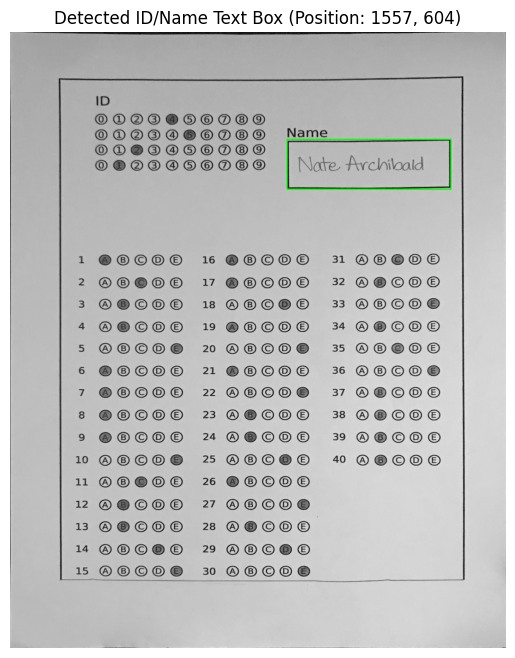

In [49]:
def find_id_text_box(image):
    """
    Finds the ID/Name text box in the warped bubble sheet image.
    Returns the bounding box coordinates (x, y, w, h) and the cropped region.
    """
    # Convert to grayscale if needed
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image.copy()
    
    # Convert to uint8 if it's a float image (0-1 range)
    if gray.dtype != np.uint8:
        gray = (gray * 255).astype(np.uint8)
    
    img_h, img_w = gray.shape
    print(f"Image size: {img_w}x{img_h}, dtype: {gray.dtype}")
    
    # Apply adaptive thresholding to find edges/borders
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV, 41, 10)
    
    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    
    potential_boxes = []
    
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        aspect_ratio = w / float(h)
        area = w * h
        
        # Filter criteria for the ID text box:
        # 1. Aspect ratio between 1.5 and 6 (wider than tall)
        # 2. Area at least 0.3% of image area
        # 3. Located in top 35% of the image
        # 4. Located in the right 70% of the image (ID box is on the right side)
        # 5. The contour should be relatively "filled" (rectangular shape)
        
        area_ratio = area / (img_h * img_w)
        fill_ratio = cv2.contourArea(cnt) / (w * h) if w * h > 0 else 0
        
        if (1.5 < aspect_ratio < 6.0 and 
            area_ratio > 0.003 and 
            y < (img_h * 0.35) and
            x > (img_w * 0.3) and
            fill_ratio > 0.5):
            potential_boxes.append((x, y, w, h, area))
            print(f"  Candidate box: x={x}, y={y}, w={w}, h={h}, aspect={aspect_ratio:.2f}, area_ratio={area_ratio:.4f}")
    
    if not potential_boxes:
        print("No text box found!")
        return None, None
    
    # Sort by area (descending) and pick the largest one that fits our criteria
    potential_boxes = sorted(potential_boxes, key=lambda b: b[4], reverse=True)
    
    # Get the best candidate (largest area that meets criteria)
    x, y, w, h, _ = potential_boxes[0]
    
    return (x, y, w, h), gray

# Step 2: Find the ID text box
box_coords, gray_warped = find_id_text_box(pre_processed_image)

if box_coords:
    x, y, w, h = box_coords
    print(f"\n✓ Found text box at: x={x}, y={y}, width={w}, height={h}")
    
    # Draw the detected box on the image
    debug_img = (pre_processed_image * 255).astype(np.uint8) if pre_processed_image.max() <= 1.0 else pre_processed_image.astype(np.uint8)
    debug_img = cv2.cvtColor(debug_img, cv2.COLOR_GRAY2RGB)
    cv2.rectangle(debug_img, (x, y), (x + w, y + h), (0, 255, 0), 5)
    
    # Show the result
    plt.figure(figsize=(12, 8))
    plt.title(f"Detected ID/Name Text Box (Position: {x}, {y})")
    plt.imshow(debug_img)
    plt.axis('off')
    plt.show()
else:
    print("Could not find the text box!")

## Step 3: Extract Text from the ID Box
Now we crop the detected text box, apply preprocessing to enhance the text, and use OCR to extract the student ID.

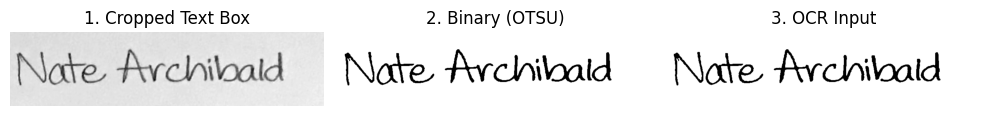

Running OCR...


c:\Python312\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



OCR Results (Original): [([[np.int32(6), np.int32(36)], [np.int32(738), np.int32(36)], [np.int32(738), np.int32(156)], [np.int32(6), np.int32(156)]], 'Nate Archibald', np.float64(0.5810808120179458))]
OCR Results (Binary):   [([[np.int32(6), np.int32(36)], [np.int32(738), np.int32(36)], [np.int32(738), np.int32(156)], [np.int32(6), np.int32(156)]], 'Nate Archibald', np.float64(0.42033111666529954))]

✓ Extracted ID: 'Nate Archibald' (confidence: 58.11%)

FINAL RESULT - Student ID: Nate Archibald


In [50]:
def extract_student_id(image, box_coords, reader):
    """
    Extracts the student ID from the detected text box using OCR.
    
    Args:
        image: The warped bubble sheet image
        box_coords: Tuple (x, y, w, h) of the text box location
        reader: EasyOCR reader instance
    
    Returns:
        The extracted student ID string
    """
    x, y, w, h = box_coords
    
    # Convert image to uint8 if needed
    if image.dtype != np.uint8:
        img = (image * 255).astype(np.uint8) if image.max() <= 1.0 else image.astype(np.uint8)
    else:
        img = image.copy()
    
    # Crop the text box region with a small margin to remove the border
    margin_h = int(h * 0.15)  # 15% margin on top/bottom
    margin_w = int(w * 0.05)  # 5% margin on left/right
    
    roi = img[y + margin_h : y + h - margin_h, 
              x + margin_w : x + w - margin_w]
    
    # Display the cropped region
    plt.figure(figsize=(10, 3))
    
    plt.subplot(1, 3, 1)
    plt.title("1. Cropped Text Box")
    plt.imshow(roi, cmap='gray')
    plt.axis('off')
    
    # Enhance the image for OCR
    # Apply binary thresholding to get clear text
    _, binary = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    plt.subplot(1, 3, 2)
    plt.title("2. Binary (OTSU)")
    plt.imshow(binary, cmap='gray')
    plt.axis('off')
    
    # Invert if text is white on black
    white_pixels = np.sum(binary > 127)
    black_pixels = np.sum(binary <= 127)
    if white_pixels > black_pixels:
        # Text is dark on light background - good for OCR
        ocr_input = binary
    else:
        # Invert - text should be dark on light for better OCR
        ocr_input = cv2.bitwise_not(binary)
    
    plt.subplot(1, 3, 3)
    plt.title("3. OCR Input")
    plt.imshow(ocr_input, cmap='gray')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Run OCR on both the original ROI and the processed version
    print("Running OCR...")
    
    # Try OCR on original grayscale ROI
    results_original = reader.readtext(roi)
    
    # Try OCR on processed binary image
    results_binary = reader.readtext(ocr_input)
    
    print(f"\nOCR Results (Original): {results_original}")
    print(f"OCR Results (Binary):   {results_binary}")
    
    # Combine and extract the best result
    all_results = results_original + results_binary
    
    if all_results:
        # Get the text with highest confidence
        best_result = max(all_results, key=lambda r: r[2])
        student_id = best_result[1]
        confidence = best_result[2]
        print(f"\n✓ Extracted ID: '{student_id}' (confidence: {confidence:.2%})")
        return student_id
    else:
        print("\n✗ No text detected!")
        return None

# Step 3: Extract the student ID
if box_coords:
    student_id = extract_student_id(pre_processed_image, box_coords, reader)
    print(f"\n{'='*50}")
    print(f"FINAL RESULT - Student ID: {student_id}")
    print(f"{'='*50}")
else:
    print("Cannot extract ID - text box not found!")

## Complete Function: Get Student ID from Bubble Sheet
This function combines all steps into one reusable function that takes an image path and returns the student ID.

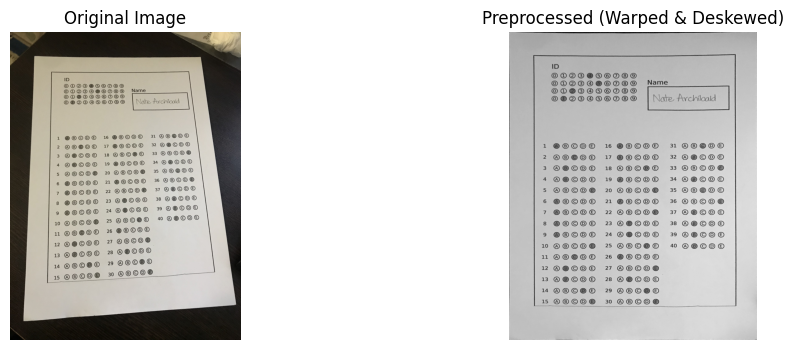

Image size: 2788x3469, dtype: uint8
  Candidate box: x=1566, y=611, w=904, h=267, aspect=3.39, area_ratio=0.0250
  Candidate box: x=1557, y=604, w=921, h=281, aspect=3.28, area_ratio=0.0268


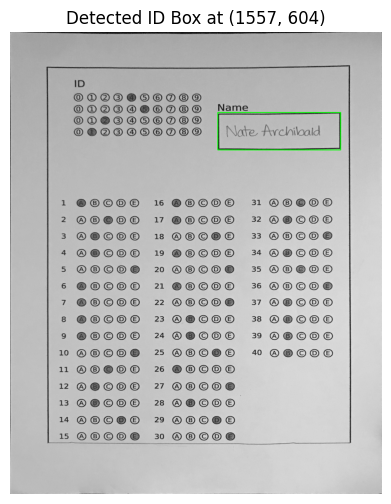

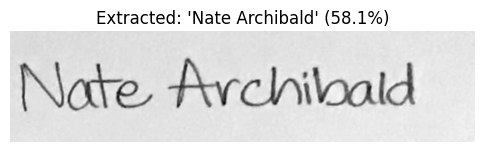


EXTRACTED STUDENT ID: Nate Archibald


In [52]:
def get_student_id_from_sheet(image_path, reader, show_steps=True):
    """
    Complete function to extract student ID from a bubble sheet image.
    
    Args:
        image_path: Path to the bubble sheet image
        reader: EasyOCR reader instance
        show_steps: If True, display intermediate steps
    
    Returns:
        The extracted student ID string, or None if not found
    """
    # Step 1: Read and preprocess the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not read image at {image_path}")
        return None
    
    # Preprocess (warp and deskew)
    pre_processed = preprocessing(image)
    
    if show_steps:
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.title("Original Image")
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.title("Preprocessed (Warped & Deskewed)")
        plt.imshow(pre_processed, cmap='gray')
        plt.axis('off')
        plt.show()
    
    # Step 2: Find the ID text box
    box_coords, _ = find_id_text_box(pre_processed)
    
    if box_coords is None:
        print("Could not find ID text box!")
        return None
    
    x, y, w, h = box_coords
    
    if show_steps:
        debug_img = (pre_processed * 255).astype(np.uint8) if pre_processed.max() <= 1.0 else pre_processed.astype(np.uint8)
        debug_img = cv2.cvtColor(debug_img, cv2.COLOR_GRAY2RGB)
        cv2.rectangle(debug_img, (x, y), (x + w, y + h), (0, 255, 0), 5)
        
        plt.figure(figsize=(8, 6))
        plt.title(f"Detected ID Box at ({x}, {y})")
        plt.imshow(debug_img)
        plt.axis('off')
        plt.show()
    
    # Step 3: Extract the ID using OCR
    # Convert to uint8
    img = (pre_processed * 255).astype(np.uint8) if pre_processed.max() <= 1.0 else pre_processed.astype(np.uint8)
    
    # Crop with margin
    margin_h = int(h * 0.15)
    margin_w = int(w * 0.05)
    roi = img[y + margin_h : y + h - margin_h, 
              x + margin_w : x + w - margin_w]
    
    # Run OCR
    results = reader.readtext(roi)
    
    if results:
        # Get the text with highest confidence
        best_result = max(results, key=lambda r: r[2])
        student_id = best_result[1]
        confidence = best_result[2]
        
        if show_steps:
            plt.figure(figsize=(6, 2))
            plt.title(f"Extracted: '{student_id}' ({confidence:.1%})")
            plt.imshow(roi, cmap='gray')
            plt.axis('off')
            plt.show()
        
        return student_id
    
    return None

# Test the complete function
test_path = "./Bubble_Sheet_Dataset/3/ID4Q40CH5/IMG_2029.jpg"
extracted_id = get_student_id_from_sheet(test_path, reader, show_steps=True)
print(f"\n{'='*50}")
print(f"EXTRACTED STUDENT ID: {extracted_id}")
print(f"{'='*50}")